## Importing the required libraries

In [47]:
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
from keras.datasets import imdb

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Embedding,Dense,Flatten
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk # for text manipulation
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
from matplotlib import pyplot as plt
from aaransia import transliterate, SourceLanguageError

import codecs
import unicodedata as ud
from tashaphyne.stemming import ArabicLightStemmer
import pyarabic.araby as araby
#from textblob import TextBlob
#from nltk.corpus import stopwords
#from nltk.stem.wordnet import WordNetLemmatizer
%matplotlib inline

## Reading and Extracting data from .csv files

In [48]:
import pandas as pd
train = pd.read_excel("C:\\Users\\DELL\\Desktop\\PFE\\Final_Data.xlsx" )
test = pd.read_excel("C:\\Users\\DELL\\Desktop\\PFE\\Test.xlsx")
stopwords= pd.read_excel("C:\\Users\\DELL\\Desktop\\PFE\\stop_words_Arabic.xlsx")

In [4]:
train2.iloc[1812:1823]

,comment,label
1812,\nالخلل في الذين يستهترون بالحجر الصحي و شروط الوقاية,1
1813,😨😨😨 هادشي لي غادي يزيد ينشر المرض في البلاد !\nاللهم الطف بنا,1
1814,Ach ghdi iakol bndam rah kyn li dkhl dyk yomi 😑 ail mdkhlch miakol f nhar mikolch o mikloch wldo,1
1815,Ah fhad lhala khassna diktatoriya dakchi li islah lina hna ila bghina ndabto,1
1816,Alla blati rah hna b3ad 3la 3a2ilatna,1
1817,Chno z3ma li dkhal ndiouh pasteur hhhh,1
1818,Fat lfout 😔,1
1819,Kdoooob makayn bo tatbi9 omat instaliw waloo tsanaw hta i9olo achman blassa lmhm wahda ftatouan ha video\n,1
1820,الدي يسهر علينا هو الله يلا مكتاب ليك تموت بكورونا ماغايشدوها عليك، من لا يحترم هو ليغيجيب متبرجة و لم اكدب عليها ماقادينش تانشوفوا فيها لأننا نخاف من ربنا و يقوليها خطبي ليهم، المرة جاية يتعرا و...,1
1821,انا بغيت غير ابين راسو و ايبان بلي بصح تيبغي شعبو ماشي اتخبى و اخلي ليبغا ايموت ايموت,1


## Exploratory Data Analysis

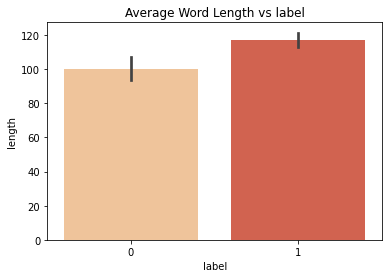

In [5]:
train['length'] = train['comment'].apply(len)
fig1 = sns.barplot('label','length',data = train,palette="OrRd" )
plt.title('Average Word Length vs label')
plot = fig1.get_figure()
plot.savefig('Barplot.png')

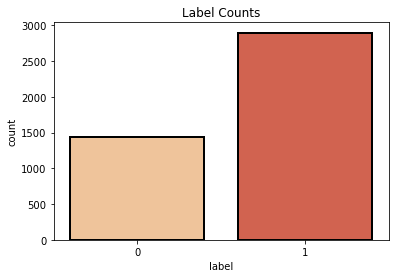

In [15]:
fig2 = sns.countplot(x= 'label',data = train,linewidth=2, edgecolor=(0,0,0),palette="OrRd")
plt.title('Label Counts')
plot = fig2.get_figure()
plot.savefig('Count Plot.png')

## Feature Engineering

### Trsanform Arabizi into Arabic

In [50]:

for i in range(len(train)):
    row=train.iloc[i]["comment"]
    row=transliterate(row, source='ma', target='ar', universal=True)
    train.loc[:,"comment"][i]=row
for i in range(len(test)):
    row=test.iloc[i]["comment"]
    row=transliterate(row, source='ma', target='ar', universal=True)
    test.loc[:,'comment'][i]=row        

<ipython-input-50-882f5eb66ddf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,"comment"][i]=row
<ipython-input-50-882f5eb66ddf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'comment'][i]=row


In [71]:
def text_processing(tweet):
    
    #Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    
    return normalization(no_punc_tweet)

In [97]:
import nltk
#nltk.download('stopwords')

#train['comment'] = train['comment'].apply(text_processing)
#test['comment'] = test['comment'].apply(text_processing)

In [72]:
combi = train.append(test, ignore_index=True)
combi.shape

(5684, 2)

In [73]:
# import Emojis 
def get_emojis():
    with codecs.open("emoji.txt", "r", encoding="utf-8", errors="ignore") as myfile:
         positive_emoji=myfile.read()
    positive_emoji=positive_emoji.split("\n")
    positive_emoji=positive_emoji[1:len(positive_emoji)-1] 
    with codecs.open("neg_emoji.txt", "r", encoding="utf-8", errors="ignore") as myfie:
        neg_emoji=myfie.read()
    neg_emoji=neg_emoji.split("\n")
    neg_emoji=neg_emoji[1:len(neg_emoji)-1]
    return positive_emoji,neg_emoji
    

############## PREPROCESSING DATA ################


#Remove stop words 
def remove_stp_words(text):
    text_words = []
    words = text.split(" ")
    stop_words = stopwords
    for word in words:
        if word not in stop_words:
            text_words.append(word)
    return ' '.join(text_words)


#Emoticons_Regex 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and '
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]
tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)

#Tokenizing_the_text :
def tokenize(s):
    return tokens_re.findall(s)


#Normalize_the_text:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


#Remove-repeating_char :
def remove_repeating_char(text):
     #return re.sub(r'(.)\1+', r'\1', text)     # keep only 1 repeat
    return re.sub(r'(.)\1+', r'\1\1', text)     # keep 2 repeat

#Detecting_Emojis_REGEX
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

#Transform Emojis to their sentiment 
def emoji_to_text(text):
    text_words = []
    words = text.split(" ")
    positive_emoji,neg_emoji=get_emojis()
    for word in words:
        if emoji_pattern.search(word):
            if word in positive_emoji :
                word='ايجابي'
            if word in neg_emoji :
                word='سلبي'
        text_words.append(word)
    return ' '.join(text_words)

#REMOVING_Punctuation
def remove_punc(text):
    return ''.join(c for c in text if not ud.category(c).startswith('P'))


#Stemmer_LIGHT : Remove suffixes and affixes 
ArListem = ArabicLightStemmer()
def stemmer_light(text):
    text_words = []
    words = text.split(" ")
    for c in words:
        stem = ArListem.light_stem(c)
        text_words.append(stem)
    return ' '.join(text_words)

#Root Stemming :  Transform the wrod into its root form
def stemmer_root(text):
    text_words = []
    words = text.split(" ")
    for c in words:
        stem = ArListem.light_stem(c)
        text_words.append(stem)
    return ' '.join(text_words)


############ DARIJA TEXT PREPROCESSIG #########

def data_clean(stp_words=False,stem=True,tok=True,emojis=False):
    data = get_data()
    sentences = data['sentence']
    #Remove ـــ character wich is used a lot in arabic for exhibition
    sentences = [araby.strip_tatweel(text) for text in sentences] 
    #Remove Punctiation 
    sentences = [remove_punc(text) for text in sentences]
    if emojis==False :
        sentences = [emoji_to_text(text) for text in sentences] 
    #Remove Repeating character
    sentences = [remove_repeating_char(text) for text in sentences]
    #Remoce arabic diacritics
    sentences = [araby.strip_tashkeel(text) for text in sentences]
    if stp_words==True :
        sentences = [remove_stp_words(text) for text in sentences]
    if stem==True:
        sentences = [stemmer_light(text) for text in sentences]
    sentences = [normalize_arabic(text) for text in sentences]
    sentences = [araby.normalize_hamza(text) for text in sentences]
    if tok==True:
        sentences = [tokenize(text) for text in sentences]
    return sentences         

In [74]:
sentences = train['comment']
    #Remove ـــ character wich is used a lot in arabic for exhibition
sentences = [araby.strip_tatweel(text) for text in sentences] 
    #Remove Punctiation 
sentences = [remove_punc(text) for text in sentences]
#if emojis==False :
sentences = [emoji_to_text(text) for text in sentences] 
    #Remove Repeating character
sentences = [remove_repeating_char(text) for text in sentences]
    #Remoce arabic diacritics
sentences = [araby.strip_tashkeel(text) for text in sentences]
#if stp_words==True :
sentences = [remove_stp_words(text) for text in sentences]
#if stem==True:
sentences = [stemmer_light(text) for text in sentences]
sentences = [normalize_arabic(text) for text in sentences]
sentences = [araby.normalize_hamza(text) for text in sentences]
#if tok==True:
sentences = [tokenize(text) for text in sentences]
#return sentences         

In [52]:
combi.iloc[3511]

comment    لماذا عد الوفيات فتزايد بالمقارنة مع عد المتعافون ناقص مع العلم انكم بديتو باستعمال الكلوروكين
label                                                                                                   1
Name: 3511, dtype: object

In [53]:
#Remove @
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [54]:
#remove @
combi['tidy_comment'] = np.vectorize(remove_pattern)(combi['comment'], "@[\w]*") 


In [55]:
#combi['tidy_comment'] = combi['tidy_comment'].str.replace("[^a-zA-Z#]", " ")


In [56]:
#remove imojies
combi['tidy_comment'] = combi['tidy_comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [57]:
combi.head()

,comment,label,tidy_comment
0,العتماني عندو الباقة و الجدال بالغة سد فمك,0.0,العتماني عندو الباقة الجدال بالغة
1,ان كتب لنا الموت بهذا الفيروس فذاك يبقا قضاء و قدر و سب من الاسباب و ان كتب لنا ان نعيش بعده فحتما، عاجلا ام اجلا سنموت اهم شيء الرجوع الا اله و الاستغفار و نساله تعالا ان يعافينا و يرحمنا و يغفر ...,0.0,الموت بهذا الفيروس فذاك يبقا قضاء الاسباب نعيش بعده فحتما، عاجلا اجلا سنموت الرجوع الاستغفار نساله تعالا يعافينا يرحمنا يغفر الموت واحد والاسباب متعدة فلما الخوف
2,خوتي اله ينجيكم من هاد الفيروس الخبيث يا رب العالمين حظيو ريوسكم الوقاية ثم الوقاية ثم الوقاية 💚 لي قد يتابونا اله يرحم ليه الوالدين لي مقدش اله يرحم ليه الوالدين,0.0,خوتي ينجيكم الفيروس الخبيث العالمين حظيو ريوسكم الوقاية الوقاية الوقاية يتابونا يرحم الوالدين مقدش يرحم الوالدين
3,الحمد له علا ان ڤيروس كورونا لا يعيش في ما فوق 22 درجة حرارية . وما كون بقا الطايح كتر من الواقف . وخير ذليل علا هذا الكلام وزير النقل وشحال من مسوول سلم عليه وشحال من واحد سلم علا كل واحد ..!!,0.0,الحمد ڤيروس كورونا يعيش درجة حرارية الطايح الواقف وخير ذليل الكلام وزير النقل وشحال مسوول عليه وشحال واحد واحد ..!!
4,و بخصوص الكمامات فهو علا صواب الكمامة تحمي فقط المريض لا غير,0.0,بخصوص الكمامات صواب الكمامة تحمي المريض


In [58]:
tokenized_tweet = combi['tidy_comment'].apply(lambda x: x.split()) # tokenizing

In [59]:
tokenized_tweet.head(10)

0                                                                                                                                                                    [العتماني, عندو, الباقة, الجدال, بالغة]
1               [الموت, بهذا, الفيروس, فذاك, يبقا, قضاء, الاسباب, نعيش, بعده, فحتما،, عاجلا, اجلا, سنموت, الرجوع, الاستغفار, نساله, تعالا, يعافينا, يرحمنا, يغفر, الموت, واحد, والاسباب, متعدة, فلما, الخوف]
2                                                                          [خوتي, ينجيكم, الفيروس, الخبيث, العالمين, حظيو, ريوسكم, الوقاية, الوقاية, الوقاية, يتابونا, يرحم, الوالدين, مقدش, يرحم, الوالدين]
3                                                                   [الحمد, ڤيروس, كورونا, يعيش, درجة, حرارية, الطايح, الواقف, وخير, ذليل, الكلام, وزير, النقل, وشحال, مسوول, عليه, وشحال, واحد, واحد, ..!!]
4                                                                                                                                                             [بخصوص, الكمامات, صواب

In [60]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [61]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import casual_tokenize
stemmer = SnowballStemmer('arabic')

In [62]:
ar_stemmer = SnowballStemmer("arabic",True)
ar_stemmer.stem("فيروسات")
#ar_stemmer.stem("فقالوا")

'يروس'

In [63]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
combi['tidy_comment'] = tokenized_tweet

In [107]:
train['comment'].head(10)

0                                                                                                                                                                 العتماني عندو الباقة و الجدال بالغة سد فمك
1    ان كتب لنا الموت بهذا الفيروس فذاك يبقا قضاء و قدر و سب من الاسباب و ان كتب لنا ان نعيش بعده فحتما، عاجلا ام اجلا سنموت اهم شيء الرجوع الا اله و الاستغفار و نساله تعالا ان يعافينا و يرحمنا و يغفر ...
2                                         خوتي اله ينجيكم من هاد الفيروس الخبيث يا رب العالمين حظيو ريوسكم الوقاية ثم الوقاية ثم الوقاية 💚 لي قد يتابونا اله يرحم ليه الوالدين لي مقدش اله يرحم ليه الوالدين
3          الحمد له علا ان ڤيروس كورونا لا يعيش في ما فوق 22 درجة حرارية . وما كون بقا الطايح كتر من الواقف . وخير ذليل علا هذا الكلام وزير النقل وشحال من مسوول سلم عليه وشحال من واحد سلم علا كل واحد ..!!
4                                                                                                                                               و بخصوص الكمامات فهو علا صواب الكمام

In [55]:
combi['tidy_comment'].head(10)

0                                                                                                                                                                          العتماني عندو الباقة الجدال بالغة
1                                          الموت بهذا الفيروس فذاك يبقا قضاء الاسباب نعيش بعده فحتما، عاجلا اجلا سنموت الرجوع الاستغفار نساله تعالا يعافينا يرحمنا يغفر الموت واحد والاسباب متعدة فلما الخوف
2                                                                                           خوتي ينجيكم الفيروس الخبيث العالمين حظيو ريوسكم الوقاية الوقاية الوقاية يتابونا يرحم الوالدين مقدش يرحم الوالدين
3                                                                                        الحمد ڤيروس كورونا يعيش درجة حرارية الطايح الواقف وخير ذليل الكلام وزير النقل وشحال مسوول عليه وشحال واحد واحد ..!!
4                                                                                                                                                                    بخصوص الكمامات 

# Using Word2Vec

In [27]:
from gensim.models import Word2Vec

In [28]:
tokenized_tweet = combi['tidy_comment'].apply(lambda x: x.split()) # tokenizing

model_w2v = Word2Vec(tokenized_tweet, size=200,  window=5)

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_comment']), epochs=20)

(797270, 1474080)

In [29]:
model_w2v.wv.most_similar(positive="الحكومة")

[('رييس', 0.9700480699539185),
 ('الشعب', 0.9660917520523071),
 ('المواطن', 0.9625692367553711),
 ('العثماني', 0.9531437754631042),
 ('الشركات', 0.9449836611747742),
 ('مطالبة', 0.9268063306808472),
 ('المغربي', 0.9199914336204529),
 ('حكومة', 0.9111768007278442),
 ('المصانع', 0.9071332216262817),
 ('اصحاب', 0.900924801826477)]

In [30]:
model_w2v.wv.most_similar(positive="الشعب")

[('الحكومة', 0.9660915732383728),
 ('المواطن', 0.9564990401268005),
 ('العثماني', 0.9549548625946045),
 ('الشركات', 0.9547432661056519),
 ('رييس', 0.9487085342407227),
 ('المغربي', 0.9320697784423828),
 ('استهتار', 0.9274996519088745),
 ('المصانع', 0.9232598543167114),
 ('مطالبة', 0.9197332859039307),
 ('حكومة', 0.9195549488067627)]

In [31]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec
#!!!!!!!

In [32]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(5684, 200)

# Train Model using word2Vec

In [33]:
from sklearn.model_selection import train_test_split


train_w2v = wordvec_df.iloc[:4337,:]
test_w2v = wordvec_df.iloc[4337:,:]

_, _, ytrain, yvalid = train_test_split(train_w2v, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)



print(train_w2v.shape, train['label'].shape)

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]


(4337, 200) (4337,)


In [36]:
epochs = 25
batch_size = 1024
loss = "binary_crossentropy"
optimizer = "adam"
metrics = ["accuracy"]

from keras import models

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
model = models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(200,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss,optimizer=optimizer,metrics= metrics)
history = model.fit(xtrain_w2v,ytrain,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(xvalid_w2v,yvalid))


predictions = model.predict(xvalid_w2v)
predictions = [0 if i<0.5 else 1 for i in predictions]

f1_score(yvalid, predictions)
print("Accuracy: ",accuracy_score(yvalid,predictions))
print("Classification Report: ")
print(classification_report(yvalid,predictions))


Epoch 1/25
3/3 [==============================] - 1s 174ms/step - loss: 0.6181 - accuracy: 0.6422 - val_loss: 0.5549 - val_accuracy: 0.7389
Epoch 2/25
3/3 [==============================] - 0s 50ms/step - loss: 0.4950 - accuracy: 0.7720 - val_loss: 0.5043 - val_accuracy: 0.7757
Epoch 3/25
3/3 [==============================] - 0s 36ms/step - loss: 0.4761 - accuracy: 0.7967 - val_loss: 0.5134 - val_accuracy: 0.7711
Epoch 4/25
3/3 [==============================] - 0s 36ms/step - loss: 0.4709 - accuracy: 0.8010 - val_loss: 0.5064 - val_accuracy: 0.7711
Accuracy:  0.7711213517665131
Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.49      0.60       461
           1       0.77      0.93      0.84       841

    accuracy                           0.77      1302
   macro avg       0.78      0.71      0.72      1302
weighted avg       0.77      0.77      0.76      1302



In [35]:
test_pred = model.predict(test_w2v)
test_pred = [0 if i<0.5 else 1 for i in test_pred]

test['label'] = test_pred
submission = test[['comment','label']]
submission.to_excel('model_result3.xlsx', index=False)


AttributeError: 'FastText' object has no attribute 'predict'

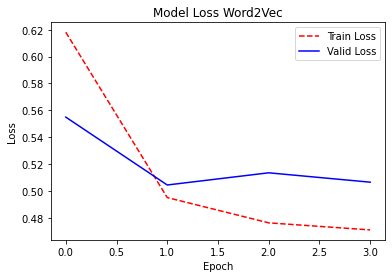

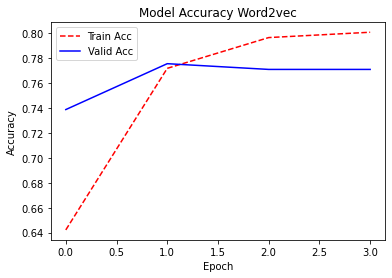

In [83]:
def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss Word2Vec')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['accuracy'],'r--')
    plt.plot(history.history['val_accuracy'],'b-')
    plt.title('Model Accuracy Word2vec')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
plot_history(history)

In [ ]:
test.head(10)

In [58]:
submission

,comment,label
0,كنشكركم ولكن ينبغي زيادة في عد تحليلات لاحاطة بالمرض,1
1,كنشكرو جميع الاطباء علا مجهوات,0
2,كنشكرو كل جهود لي كتقوم بيها وزارة راه مشي ساهل انها تقوم بمواكبة اخر مستجدات ونشرها علا مدار الساعة ولكل الاطقم موجودة داخل مستشفيات لي معندهوم اي عطلة ولا استراحة ربي يكون معاكم,1
3,كنطالب منكم تنصحو ناس لي خدمين في الامن والقوات المساعدة اديرو حتياطتهم حت هما تكونو علا تصال بزاف مع اناس لي علا برة,1
4,كنطالبو من الحكومة تفرض علا كل واحد خرج من المنزل ديالوالبس الكمامة ديالو اجباري لتفادي الاسوا.,1
...,...,...
755,موقعنا الجغرافي سلاح دو حدين مزيان و صعيب بحال هاذ الحالة د كورونا بالامكانيات لي عندنا راه براڤو علا الجميع و خاصة الطب و الداخلية و شويا الاعلام.و تحية لموالين لفلوس لي كانو رجال بالصراحة 32 ملي...,1
756,يا اخي اله المستعان. عد الاختبارات غير كاف و الفية المعنية به ضعيفة. الدول اصبحت في سباق مع الزمن لانجاز اكبر عد من الاختبارات اليومية و حصر اكبر عد من الحاملين لفيروس و المصابين. في هذه الظروف مر...,1
757,ميجيو اكملوا تحاليل حتا كلشي اتعادا🤐,1
758,ميكونوش غا الموتا، اما المتعافون يقدوا يتعافاو في مرة، كنظن هذا مزيد من الاحتياط بش يتاكدوا مزيان من الشفاء ديالهم. اله يشافيهم ويحفظنا اجمعين.,1


# FastText Using DeepLearning

In [86]:
 from gensim.models import FastText

In [87]:
print("Training a Gensim FastText model")
model = FastText(sentences=tokenized_tweet, size = 200, window = 2) # workers = workers, 
print("Training complete")

Training a Gensim FastText model
Training complete


In [88]:
model.most_similar(positive="الحكومة")

[('_', 0.06458057463169098),
 ('#', 0.059374067932367325),
 ('!', 0.035827770829200745),
 ('1', 0.033711664378643036),
 ('6', 0.02987004444003105),
 ('4', 0.02952641062438488),
 ('ء', 0.029179807752370834),
 ('؟', 0.020406633615493774),
 ('️', 0.018190763890743256),
 ('8', 0.01733882911503315)]

In [89]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [90]:
###########################################
fasttext_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    fasttext_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
fasttext_df = pd.DataFrame(fasttext_arrays)
fasttext_df.shape
#############################################

(5684, 200)

# Train Model using FastText

In [91]:
from sklearn.model_selection import train_test_split

train_ft = fasttext_df.iloc[:4337,:]
test_ft = fasttext_df.iloc[4337:,:]

_, _, ytrain, yvalid = train_test_split(train_ft, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)



print(train_ft.shape, train['label'].shape)

xtrain_ft = train_ft.iloc[ytrain.index,:]
xvalid_ft = train_ft.iloc[yvalid.index,:]

(4337, 200) (4337,)


In [94]:
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
from keras.datasets import imdb

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Embedding,Dense,Flatten
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import f1_score

epochs = 25
batch_size = 1024
loss = "binary_crossentropy"
optimizer = "adam"
metrics = ["accuracy"]

from keras import models

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
model = models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(200,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss,optimizer=optimizer,metrics= metrics)
history=model.fit(xtrain_ft,ytrain,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(xvalid_ft,yvalid))


predictions = model.predict(xvalid_ft)
predictions = [0 if i<0.5 else 1 for i in predictions]

f1_score(yvalid, predictions)
print("Accuracy: ",accuracy_score(yvalid,predictions))
print("Classification Report: ")
print(classification_report(yvalid,predictions))


Epoch 1/25
3/3 [==============================] - 0s 152ms/step - loss: 0.6511 - accuracy: 0.6771 - val_loss: 0.6758 - val_accuracy: 0.6459
Epoch 2/25
3/3 [==============================] - 0s 61ms/step - loss: 0.6363 - accuracy: 0.6781 - val_loss: 0.6532 - val_accuracy: 0.6452
Epoch 3/25
3/3 [==============================] - 0s 58ms/step - loss: 0.6290 - accuracy: 0.6781 - val_loss: 0.6492 - val_accuracy: 0.6444
Epoch 4/25
3/3 [==============================] - 0s 42ms/step - loss: 0.6273 - accuracy: 0.6784 - val_loss: 0.6509 - val_accuracy: 0.6444
Epoch 5/25
3/3 [==============================] - 0s 41ms/step - loss: 0.6250 - accuracy: 0.6784 - val_loss: 0.6524 - val_accuracy: 0.6444
Accuracy:  0.6443932411674347
Classification Report: 
              precision    recall  f1-score   support

           0       0.25      0.00      0.00       461
           1       0.65      1.00      0.78       841

    accuracy                           0.64      1302
   macro avg       0.45      0.5

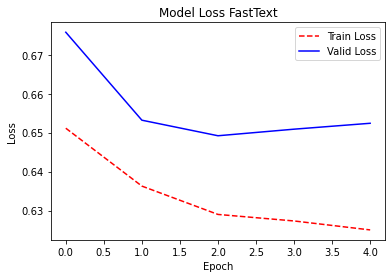

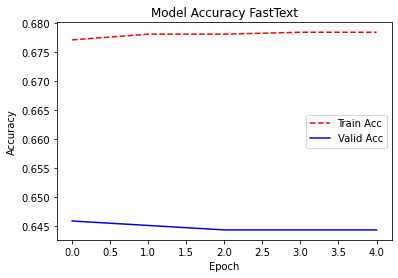

In [95]:
def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss FastText')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['accuracy'],'r--')
    plt.plot(history.history['val_accuracy'],'b-')
    plt.title('Model Accuracy FastText')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
plot_history(history)

In [67]:
test_pred = model.predict(test_w2v)
test_pred = [0 if i<0.5 else 1 for i in test_pred]

test['label'] = test_pred
submission = test[['comment','label']]
submission.to_excel('model_result3.xlsx', index=False)

# End

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
#clf = MultinomialNB(alpha=0.1, fit_prior= False).fit(xtrain_ft, ytrain)
log = LogisticRegression( solver='lbfgs',multi_class='multinomial').fit(xtrain_ft, ytrain)                                                                    
d_tree = tree.DecisionTreeClassifier().fit(xtrain_ft,ytrain)
svm = LinearSVC().fit(xtrain_ft,ytrain)
print(classification_report( log.predict(test_pred) , y_test))
print("Logistic Regression:",accuracy_score( log.predict(X_test) , y_test ),accuracy_score( log.predict(X_train) , y_train ))
print(classification_report( d_tree.predict(X_test) , y_test))
print("Decision Tree Accuracy:",accuracy_score( d_tree.predict(X_test) , y_test ),accuracy_score( d_tree.predict(X_train) , y_train ))
print(classification_report( clf.predict(X_test) , y_test))
print("MultinomialNB Accuracy:",accuracy_score( clf.predict(X_test) , y_test ),accuracy_score( clf.predict(X_train) , y_train ))
print(classification_report( svm.predict(X_test) , y_test))
print("SVM Accuracy:",accuracy_score( svm.predict(X_test) , y_test ),accuracy_score( svm.predict(X_train) , y_train ))

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Expected 2D array, got 1D array instead:
array=[1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0
 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()